**Hyperspectral Target Detection**   
**Author: Ramesh Bhatta, CIS, RIT**  
**Data: SHARE 2010 HSI data**

This work was done to use few target detection algorithms in Hyperspectral Images and do their performance analysis. We used four algorithms namely: 
- 1) Spectral Angle Mapper (SAM), 
- 2) Spectral Matched Filter (SMF),
- 3) Adaptive Cosine/Coherence Estimator (ACE) and 
- 4) Constraint Energy minimization (CEM) algorithms.   

These algorithms were applied in both original space and also in the Principal Components Space and outputs were generated. The dataset used was “SHARE 2010 HSI data” provided by **Dr. Emmet Ientilucci** (more description in readme section). The step-by-step processing method and code is provided below:

In [3]:
## Import Spectral Libraries

import spectral.io.envi as envi
import spectral
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import read_roi

In [35]:
## Predefined plot preferences

# Define text sizes
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

# Apply text size settings
plt.rc('font', size=SMALL_SIZE)          # Default font size
plt.rc('axes', titlesize=MEDIUM_SIZE)   # Axis title font size
plt.rc('axes', labelsize=MEDIUM_SIZE)   # Axis labels font size
plt.rc('xtick', labelsize=SMALL_SIZE)   # X-axis tick label font size
plt.rc('ytick', labelsize=SMALL_SIZE)   # Y-axis tick label font size
plt.rc('legend', fontsize=SMALL_SIZE)   # Legend font size
plt.rc('figure', titlesize=BIGGER_SIZE) # Figure title font size

**1. Reading the HSI data and red felt reflectance curve.**

In [36]:
## Read The hyperspectral Image

thor_hsi_data = envi.open('001_0729-1919_rad_GeoRef_THOR_ELM_smoothed 146x84.hdr', '001_0729-1919_rad_GeoRef_THOR_ELM_smoothed 146x84.img')
red_felt_ref = pd.read_csv('Red Felt Refl ASD Reseamp 360 ASCII.txt', sep='   ', header=None, names=['wavelength', 'reflectance'], engine='python')

In [37]:
## Replace bands 114-123, 143-153, 182-197, 253-280, 320-360  from red felt reference and give nan value.

red_felt_ref.loc[113:122, 'reflectance'] = np.nan
red_felt_ref.loc[142:152, 'reflectance'] = np.nan
red_felt_ref.loc[181:196, 'reflectance'] = np.nan
red_felt_ref.loc[252:279, 'reflectance'] = np.nan
red_felt_ref.loc[319:359, 'reflectance'] = np.nan

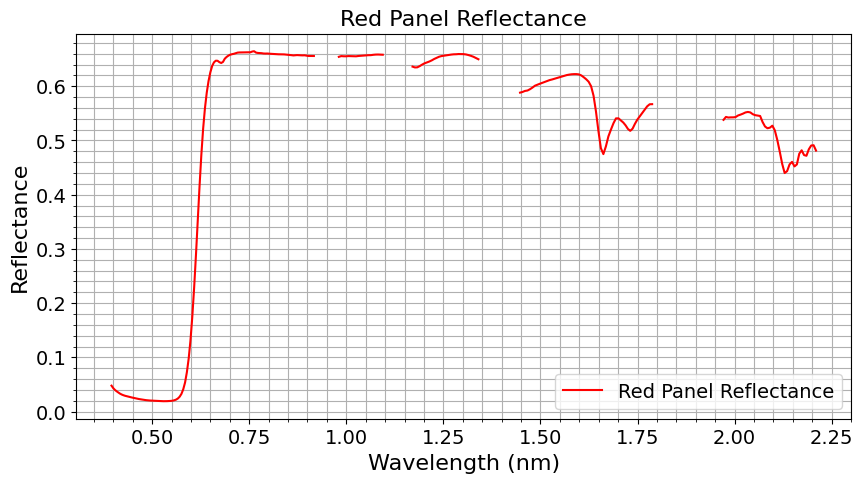

In [38]:
## Plot of red felt reflectance

# Create a temporary numeric version of 'wavelength'
wavelength_numeric = pd.to_numeric(red_felt_ref['wavelength'], errors='coerce')

fig = plt.figure(figsize=(10, 5))
plt.plot(wavelength_numeric, red_felt_ref['reflectance'], label='Red Panel Reflectance', color='red', linewidth=1.5)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Red Panel Reflectance')
plt.grid(which='both')
plt.minorticks_on()
plt.legend()
plt.show()

### <u>**TARGET DETECTION IN ORIGINAL SPACE**</u>

**Q2a: Perform detection with SAM, MF, ACE and CEM (mean centered).  Display these results using the data in regular spectral space (as opposed to dimensionally reduced space).** 

In [7]:
## Removing Bad Bands

good_bands = ~np.isnan(red_felt_ref['reflectance']).to_numpy()
good_bands_indices = np.where(good_bands)[0]
reference_spectrum = red_felt_ref['reflectance'].to_numpy()[good_bands]
hsi_data_array = thor_hsi_data.load()
hsi_data = hsi_data_array[:, :, good_bands_indices]

**Spectral Angle Mapper**

/var/folders/_z/xfqh2srd4zg69mc724gvhc6m0000gn/T/ipykernel_37549/4052031890.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dot_product = np.dot(spectrum, reference_spectrum) / (np.linalg.norm(spectrum) * np.linalg.norm(reference_spectrum))
/var/folders/_z/xfqh2srd4zg69mc724gvhc6m0000gn/T/ipykernel_37549/4052031890.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sam_result[i, j] = -np.arccos(dot_product)


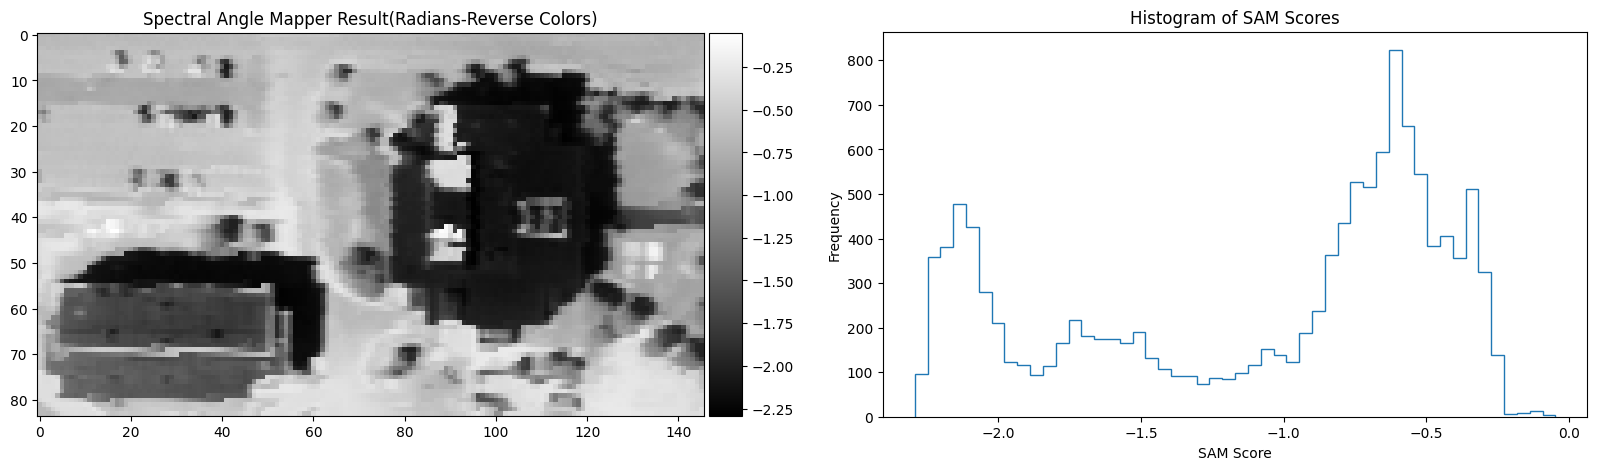

In [8]:
## Spectral Angle Mapper

def calculate_sam(hsi_data, reference_spectrum):

    # Create a numpy array of zeros with the same shape as the HSI image
    sam_result = np.zeros((hsi_data.shape[0], hsi_data.shape[1]))
    
    # Loop through each pixel in the HSI image and calculate the SAM value
    for i in range(hsi_data.shape[0]):
        for j in range(hsi_data.shape[1]):
            
            # Read the spectrum for the current pixel
            spectrum = hsi_data[i, j, :]
            
            # Calculate the dot product
            dot_product = np.dot(spectrum, reference_spectrum) / (np.linalg.norm(spectrum) * np.linalg.norm(reference_spectrum))
            
            # Calculate the spectral angle
            sam_result[i, j] = -np.arccos(dot_product)
    
    return sam_result


# Calculate the SAM result
sam_result = calculate_sam(hsi_data, reference_spectrum)

# Plot the SAM result
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
im = axs[0].imshow(sam_result, cmap='gray')
axs[0].set_title('Spectral Angle Mapper Result(Radians-Reverse Colors)')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

# Plot the histogram of the SAM scores
axs[1].hist(sam_result.ravel(), bins=50, histtype='step')
axs[1].set_title('Histogram of SAM Scores')
axs[1].set_xlabel('SAM Score')
axs[1].set_ylabel('Frequency')
plt.show()

**Spectral Matched Filter**

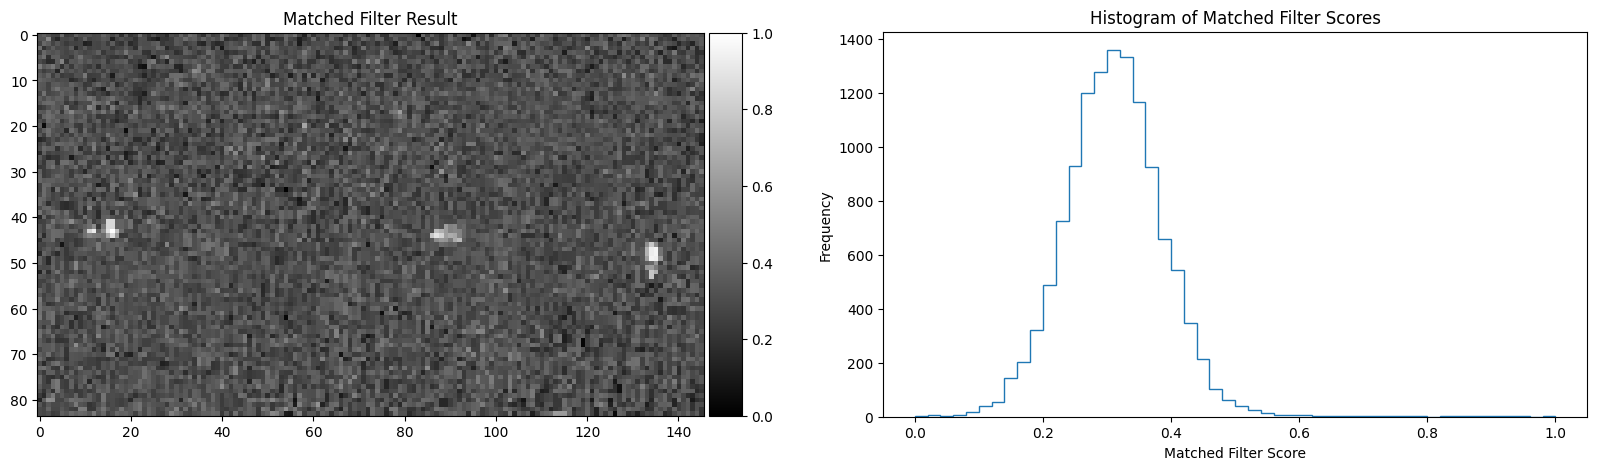

In [9]:
## Use Spectral Matched Filter for target detection

def calculate_matched_filter(hsi_data, reference_spectrum):
    
    # Initialize an empty array for the matched filter result
    matched_filter_result = np.zeros((hsi_data.shape[0], hsi_data.shape[1]))

    # Calculate the mean of the HSI data- backround
    mean_hsi = np.mean(hsi_data, axis=(0, 1))

    # Calculate the covariance of the HSI data
    cov_hsi = np.cov(hsi_data.reshape(-1, hsi_data.shape[-1]).T)

    # Calculate the inverse of the covariance matrix
    inv_cov_hsi = np.linalg.inv(cov_hsi)
    
    # Use SVD to calculate the inverse of the covariance matrix
    # U, S, V = np.linalg.svd(cov_hsi)
    # inv_cov_hsi = np.dot(V.T, np.dot(np.diag(1/S), U.T))
    

    # Calculate the filter hh
    h = np.dot(inv_cov_hsi, (reference_spectrum - mean_hsi))

    # Loop through each pixel in the HSI image and calculate the MF value
    for i in range(hsi_data.shape[0]):
        for j in range(hsi_data.shape[1]):

            # Calculate the MF value
            matched_filter_result[i, j] = np.dot(h.T, hsi_data[i, j])

    # normalize the matched filter result using min-max normalization
    matched_filter_result = (matched_filter_result - np.min(matched_filter_result)) / (np.max(matched_filter_result) - np.min(matched_filter_result))
    return matched_filter_result
    
## Calculate the matched filter result
matched_filter_result = calculate_matched_filter(hsi_data, reference_spectrum)

## Plot the matched filter result
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
im = axs[0].imshow(matched_filter_result, cmap='gray')
axs[0].set_title('Matched Filter Result')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

## Plot the histogram of the matched filter scores
axs[1].hist(matched_filter_result.ravel(), bins=50, histtype='step')
axs[1].set_title('Histogram of Matched Filter Scores')
axs[1].set_xlabel('Matched Filter Score')
axs[1].set_ylabel('Frequency')
plt.show()



**Adaptive Cosine/Coherence Estimator**

/var/folders/_z/xfqh2srd4zg69mc724gvhc6m0000gn/T/ipykernel_37549/1016928470.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  hsi_spectrum_mean_subtracted = hsi_spectrum - background_mean


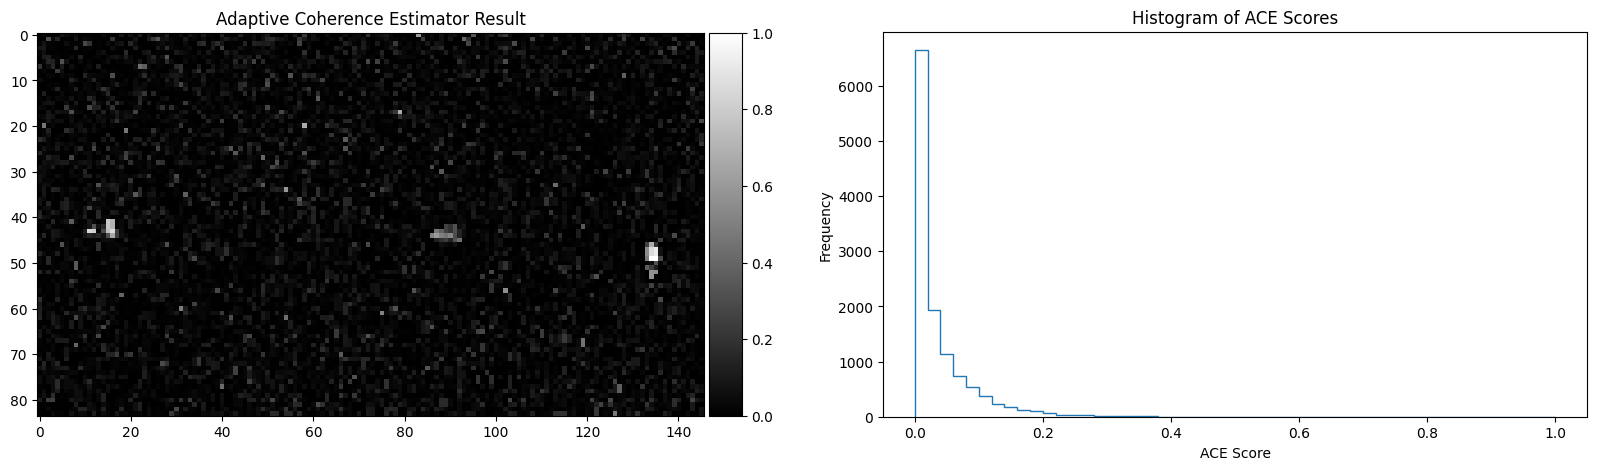

In [10]:
## Use Adaptive Coherence Estimator for target detection

from scipy.linalg import inv

def calculate_ace(hsi_spectrum, reference_spectrum):
    
    # Calculate the mean and covariance of the background
    background_mean = np.mean(hsi_spectrum, axis=(0, 1))
    
    # Subtract the mean of the background from the hyperspectral image
    hsi_spectrum_mean_subtracted = hsi_spectrum - background_mean

    # Reshape the mean-centered hyperspectral image data into a 2D array where each row is a pixel
    hsi_spectrum_2d = hsi_spectrum_mean_subtracted.reshape(-1, hsi_spectrum.shape[-1])

    # Calculate the covariance of the background
    background_cov = np.zeros((hsi_spectrum.shape[-1], hsi_spectrum.shape[-1]))
    for pixel in hsi_spectrum_2d:
        background_cov += np.outer(pixel, pixel)
    background_cov /= hsi_spectrum_2d.shape[0]

    # Calculate the inverse of the background covariance
    background_cov_inv = inv(background_cov)
    
    # use SVD to calculate the inverse of the background covariance
    # U, S, V = np.linalg.svd(background_cov)
    # background_cov_inv = np.dot(V.T, np.dot(np.diag(1/S), U.T))
    
    # Subtract the mean of the background from the target and the hyperspectral image
    target_mean = reference_spectrum - background_mean

    # Calculate the ACE score for each pixel
    ace_scores = np.empty(hsi_spectrum.shape[:2])
    for i in range(hsi_spectrum.shape[0]):
        for j in range(hsi_spectrum.shape[1]):
            x = hsi_spectrum_mean_subtracted[i, j]
            numerator = (target_mean.T @ background_cov_inv @ x) ** 2
            denominator = (target_mean.T @ background_cov_inv @ target_mean) * (x.T @ background_cov_inv @ x)
            ace_scores[i, j] = numerator / denominator
            
    # Normalize the ACE scores to the range [0, 1]        
    ace_scores = (ace_scores - np.min(ace_scores)) / (np.max(ace_scores) - np.min(ace_scores))
    return ace_scores

## Calculate the ACE result
ace_result = calculate_ace(hsi_data, reference_spectrum)

## Plot the ACE result
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
im = axs[0].imshow(ace_result, cmap='gray')
axs[0].set_title('Adaptive Coherence Estimator Result')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

## Plot the histogram of the ACE scores
axs[1].hist(ace_result.ravel(), bins=50, histtype='step')
axs[1].set_title('Histogram of ACE Scores')
axs[1].set_xlabel('ACE Score')
axs[1].set_ylabel('Frequency')
plt.show()

**Constrained Energy Minimization**

/var/folders/_z/xfqh2srd4zg69mc724gvhc6m0000gn/T/ipykernel_37549/1132367370.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = hsi_data[i, j] - np.mean(hsi_data_2d, axis=0)


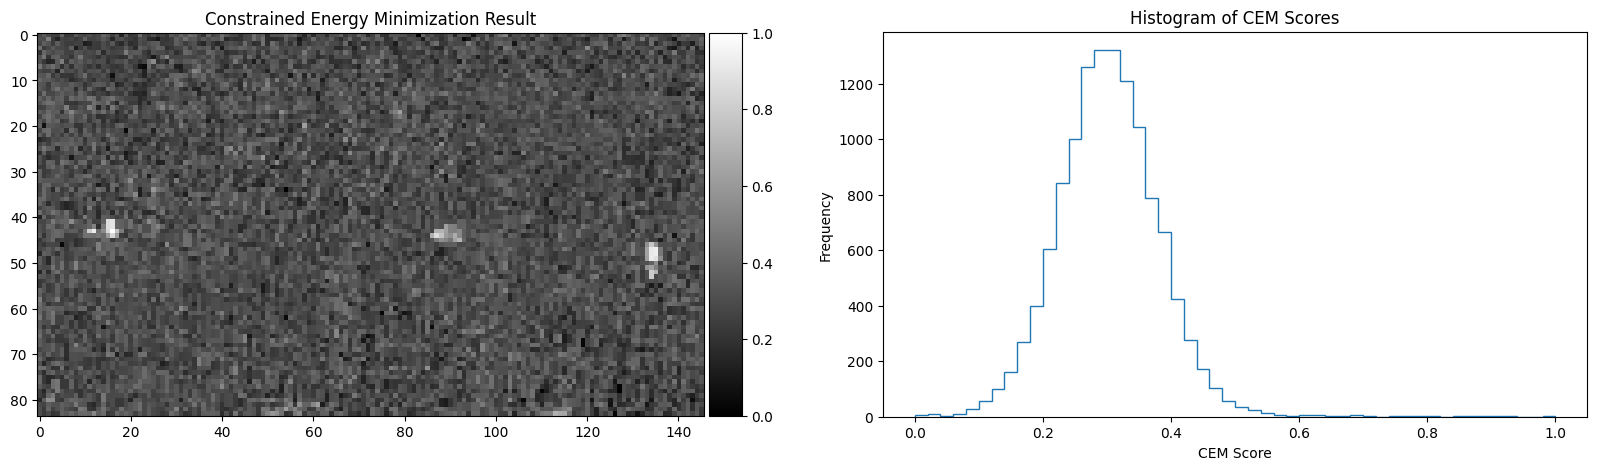

In [11]:
## Use Constrained Energy Minimization for target detection

def calculate_cem(hsi_data, reference_spectrum):
    
    # Reshape the hyperspectral image data into a 2D array where each row is a pixel
    hsi_data_2d = hsi_data.reshape(-1, hsi_data.shape[2])
    
    # Mean center the data
    hsi_data_2d = hsi_data_2d - np.mean(hsi_data_2d, axis=0)
    
    # Calculate the correlation matrix
    R = np.zeros((hsi_data_2d.shape[1], hsi_data_2d.shape[1]))
    for i in range(hsi_data_2d.shape[0]):
        R += np.outer(hsi_data_2d[i], hsi_data_2d[i])    
    R = R / hsi_data_2d.shape[0]

    # Calculate the inverse of the correlation matrix
    R_inv = inv(R)
    
    # use SVD to calculate the inverse of the correlation matrix
    # U, S, V = np.linalg.svd(R)
    # R_inv = np.dot(V.T, np.dot(np.diag(1/S), U.T))
    
    reference_spectrum = reference_spectrum - np.mean(hsi_data_2d, axis=0)
    
    # Calculate the CEM score for each pixel
    cem_scores = np.empty(hsi_data.shape[:2])
    for i in range(hsi_data.shape[0]):
        for j in range(hsi_data.shape[1]):
            x = hsi_data[i, j] - np.mean(hsi_data_2d, axis=0)
            numerator = np.dot(np.dot(reference_spectrum.T, R_inv), x)
            denominator = np.dot(np.dot(reference_spectrum.T, R_inv), reference_spectrum)
            cem_scores[i, j] = numerator / denominator

    # Normalize the CEM scores to the range [0, 1]
    cem_scores = (cem_scores - np.min(cem_scores)) / (np.max(cem_scores) - np.min(cem_scores))
    
    return cem_scores

## Calculate the CEM result
cem_result = calculate_cem(hsi_data, reference_spectrum)

## Plot the CEM result
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
im = axs[0].imshow(cem_result, cmap='gray')
axs[0].set_title('Constrained Energy Minimization Result')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

## Plot the histogram of the CEM scores
axs[1].hist(cem_result.ravel(), bins=50, histtype='step')
axs[1].set_title('Histogram of CEM Scores')
axs[1].set_xlabel('CEM Score')
axs[1].set_ylabel('Frequency')
plt.show()

**Q2C: Build Truth Mask**

/var/folders/_z/xfqh2srd4zg69mc724gvhc6m0000gn/T/ipykernel_37549/3651606321.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  class_map = (class_map - np.min(class_map)) / (np.max(class_map) - np.min(class_map))


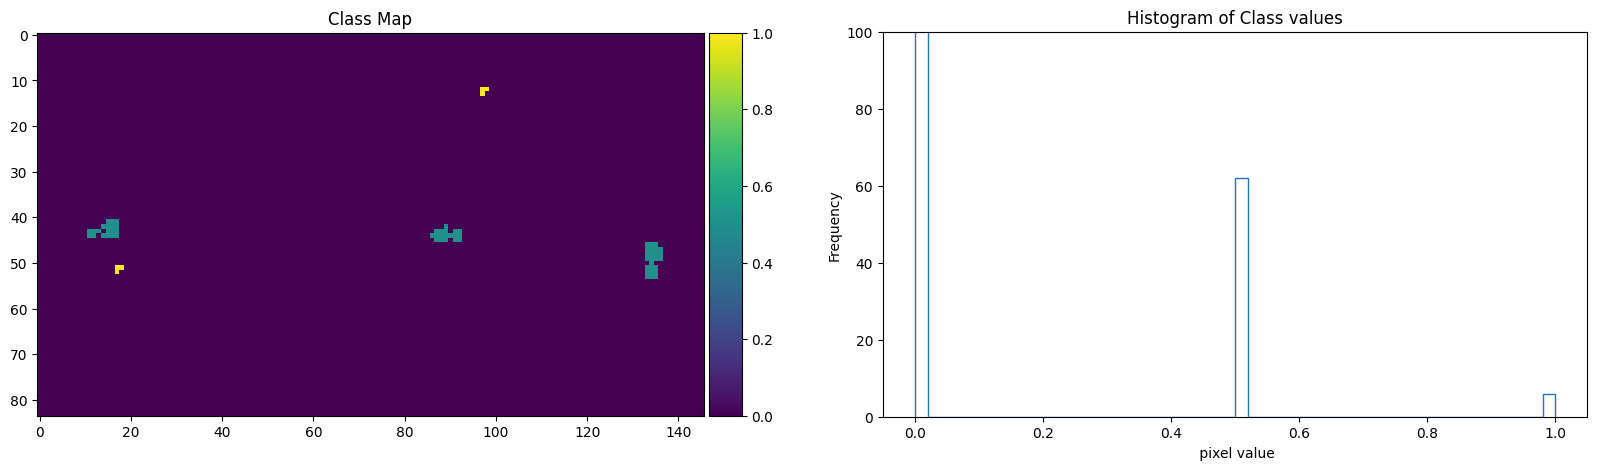

In [12]:
# Import the class map made using envi

class_map = envi.open('classmap.hdr', 'classmap.img')
class_map= class_map.load()

#normalizing the class map using min-max normalization
class_map = (class_map - np.min(class_map)) / (np.max(class_map) - np.min(class_map))
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
im = axs[0].imshow(class_map, cmap='viridis')
axs[0].set_title('Class Map')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

## Plot the histogram of the CEM scores
axs[1].hist(class_map.ravel(), bins=50, histtype='step')
axs[1].set_title('Histogram of Class values')
axs[1].set_xlabel(' pixel value')
axs[1].set_ylabel('Frequency')
axs[1].set_ylim(0, 100)
plt.show()

**Q2D: Performing Histogram Filtering/Thresholding to find Targets**

In [13]:
## Thresholding the Detection Results:

def thresholding(detector_result, lower_bound, upper_bound, name):
    result = detector_result.copy()
    result[result < lower_bound] = 1
    result[(result > lower_bound) & (result < upper_bound)] = 0
    result[result > upper_bound] = 1
    thres_result = -result
    
    ## Plot the thresholded result and its histogram
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    im = axs[0].imshow(thres_result, cmap='gray')
    axs[0].set_title(f'Thresholded Result for {name}')
    
    axs[1].hist(detector_result.ravel(), bins=50, histtype='step')
    axs[1].set_title(f'Histogram of {name} Result With Thresholding bounds')
    axs[1].axvline(x=lower_bound, color='green', linestyle='--', label=f'Lower Bound: {lower_bound}')
    axs[1].axvline(x=upper_bound, color='red', linestyle='--', label=f'Upper Bound: {upper_bound}')
    axs[1].set_xlabel('Score')
    axs[1].set_ylabel('Frequency')
    axs[1].legend()
    plt.show()
    return None

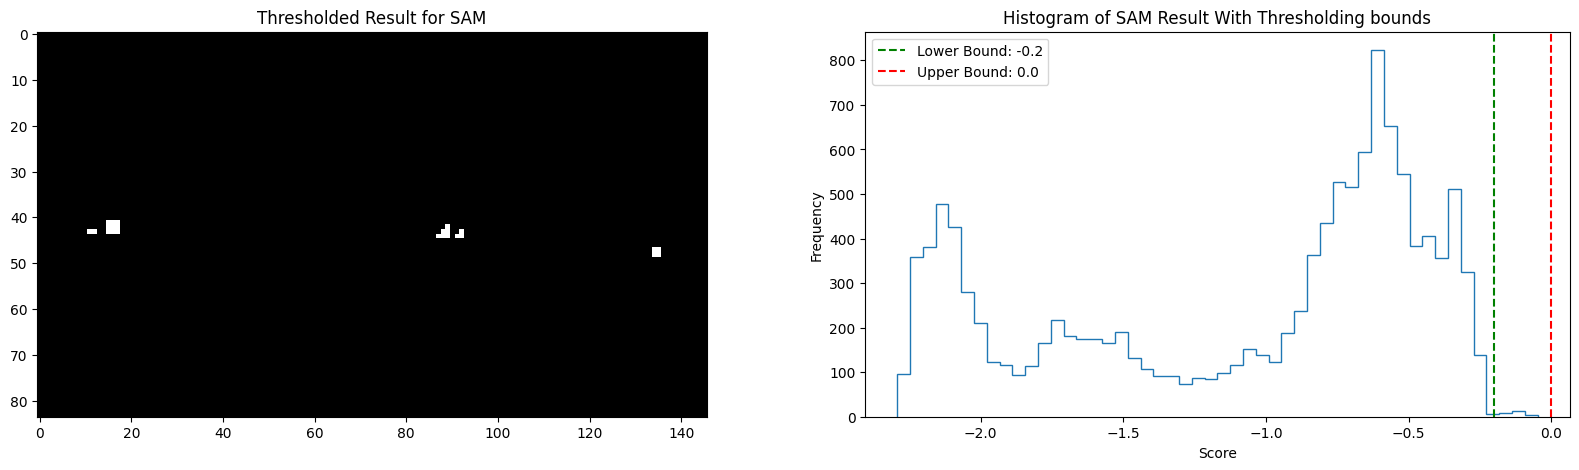

In [14]:
## Thresholding the SAM result
thresholding(sam_result, -0.2, 0.0, 'SAM')

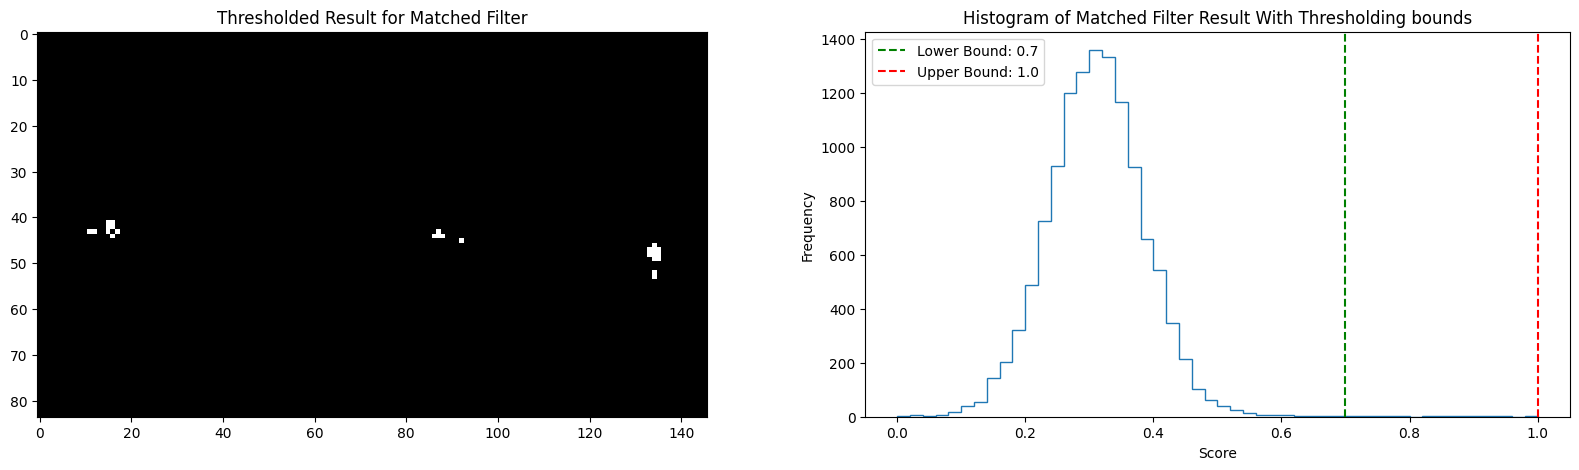

In [15]:
## Thresholding the matched filter result
thresholding(matched_filter_result, 0.7, 1.0, 'Matched Filter')

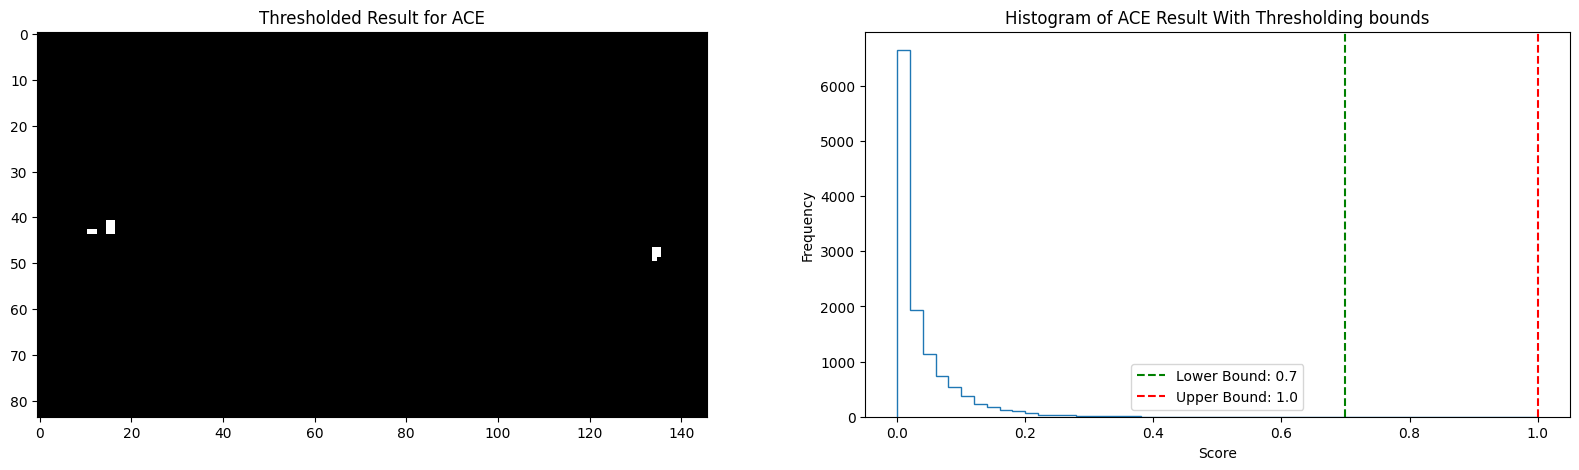

In [16]:
## Thresholding the ACE result
thresholding(ace_result, 0.7, 1.0, 'ACE')

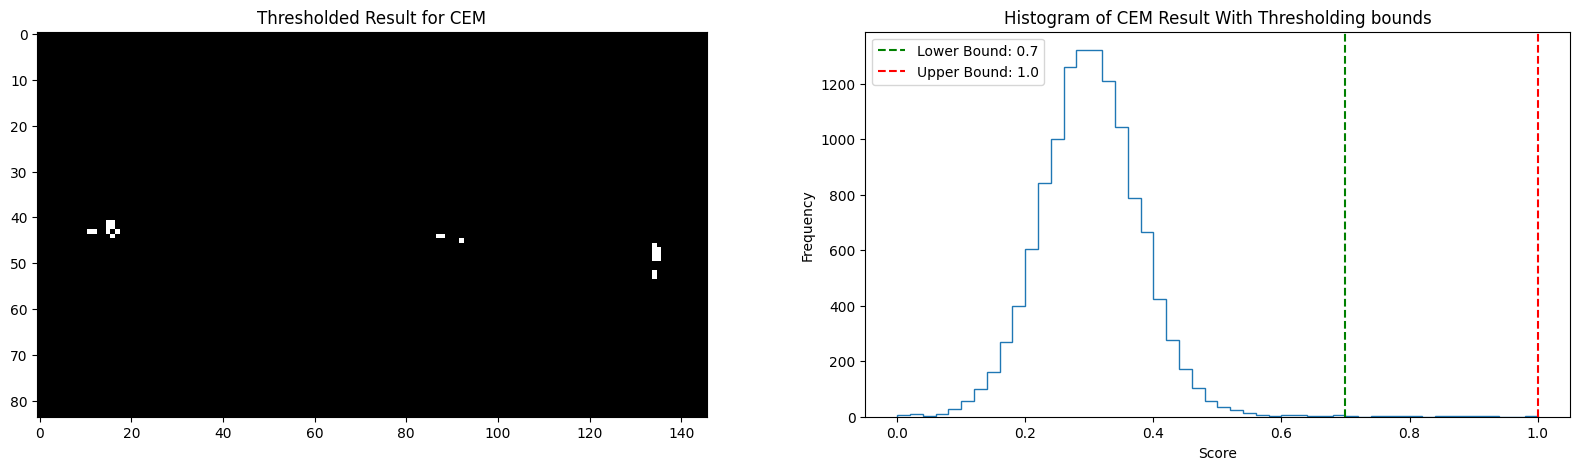

In [17]:
## Thresholding the CEM result
thresholding(cem_result, 0.7, 1.0, 'CEM')

**Q2E: ROC curve for each detector(linear and log plot)**

In [18]:
## Making ROC curves for each detector in same plot using the class map

def roc_curve(detector_result, class_map):
    
    class_map = (class_map >= 0.5).astype(int)
    
    # sor the detection results from high to low
    sorted_indices = np.argsort(detector_result.ravel())[::-1]
    sorted_detector_result = detector_result.ravel()[sorted_indices]
    
    # Flatten the class map
    class_map_flat = class_map.ravel()
    
    # if for sorted detector result, the class map is >0.5, then it is a hit, just plot hits vs all pixels
    hits = np.cumsum(class_map_flat[sorted_indices])
    all_pixels = np.arange(len(detector_result.ravel())) + 1
    hit_rate = hits / np.sum(class_map_flat)
    
    ## AUC calculation
    auc = np.trapz(hit_rate, all_pixels / np.max(all_pixels))
    
    return (all_pixels, hit_rate, auc)

/var/folders/_z/xfqh2srd4zg69mc724gvhc6m0000gn/T/ipykernel_37549/1180817907.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(hit_rate, all_pixels / np.max(all_pixels))


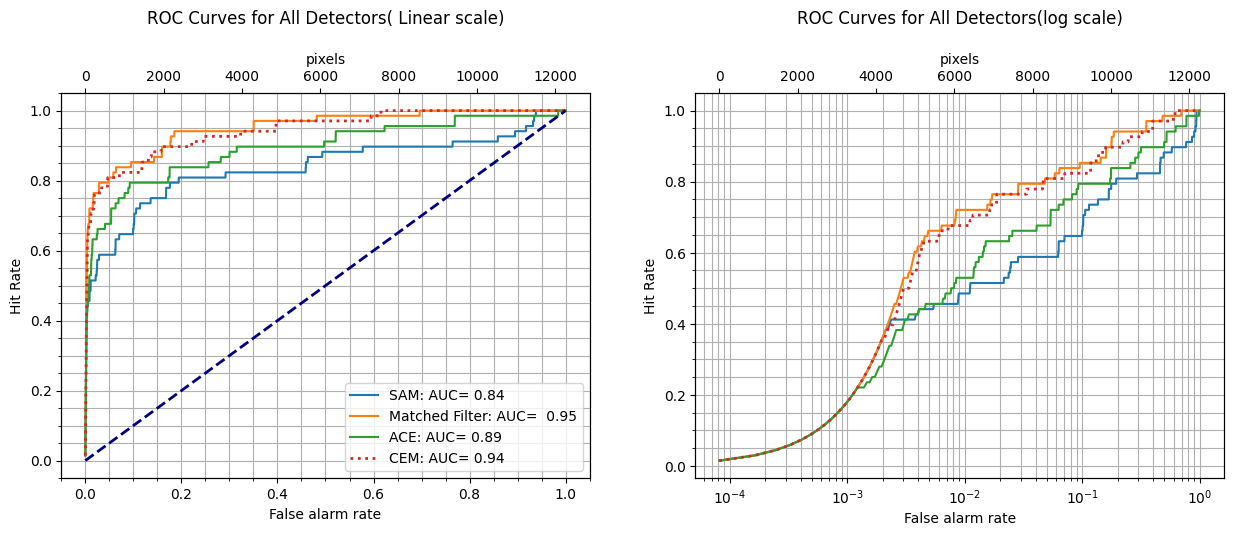

In [19]:
from matplotlib.ticker import FuncFormatter

## ROC curve for All detectors

def all_roc(sam_result, matched_filter_result, ace_result, cem_result, class_map):
    
    sam_roc = roc_curve(sam_result, class_map)
    matched_filter_roc = roc_curve(matched_filter_result, class_map)
    ace_roc = roc_curve(ace_result, class_map)
    cem_roc = roc_curve(cem_result, class_map)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    #Plot in linear scale
    norm = np.max(sam_roc[0])
    ax[0].plot(sam_roc[0]/norm, sam_roc[1], label=f'SAM: AUC= {sam_roc[2]:.2f}')
    ax[0].plot(matched_filter_roc[0]/norm, matched_filter_roc[1], label=f'Matched Filter: AUC=  {matched_filter_roc[2]:.2f}')
    ax[0].plot(ace_roc[0]/norm, ace_roc[1], label=f'ACE: AUC= {ace_roc[2]:.2f}')
    ax[0].plot(cem_roc[0]/norm, cem_roc[1], label=f'CEM: AUC= {cem_roc[2]:.2f}', linestyle='dotted', linewidth=2)
    ax[0].plot([0, np.max(sam_roc[0])/norm], [0, 1 ], color='navy', lw=2, linestyle='--')
    ax[0].set_xlabel('False alarm rate')
    ax[0].set_ylabel('Hit Rate')
    ax[0].set_title('ROC Curves for All Detectors( Linear scale)\n ')
    ax[0].grid(which='both')
    ax[0].minorticks_on()
    ax[0].legend()
    ax0_2 = ax[0].twiny()
    ax0_2.plot(sam_roc[0] , sam_roc[1], alpha=0)
    ax0_2.set_xlabel('pixels')

    ## Plot in log plots

    ax[1].semilogx(sam_roc[0]/norm, sam_roc[1], label='SAM')
    ax[1].semilogx(matched_filter_roc[0]/norm, matched_filter_roc[1], label='Matched Filter')
    ax[1].semilogx(ace_roc[0]/norm, ace_roc[1], label='ACE')
    ax[1].semilogx(cem_roc[0]/norm, cem_roc[1], label='CEM', linestyle='dotted', linewidth=2)
    ax[1].set_xlabel('False alarm rate')
    ax[1].set_ylabel('Hit Rate')
    ax[1].set_title('ROC Curves for All Detectors(log scale)\n ')
    ax[1].grid(which='both')
    ax[1].minorticks_on()
    ax1_2 = ax[1].twiny()
    ax1_2.plot(sam_roc[0], sam_roc[1], alpha=0)
    ax1_2.set_xlabel('pixels')
    plt.show()
    
    return None

## ROC curve for all detectors
all_roc(sam_result, matched_filter_result, ace_result, cem_result, class_map)

### <u>**Q3: Analysis In Reduced Dimensional Space**</u>

**Q3A: Using PCA to Reduce Dimensions**


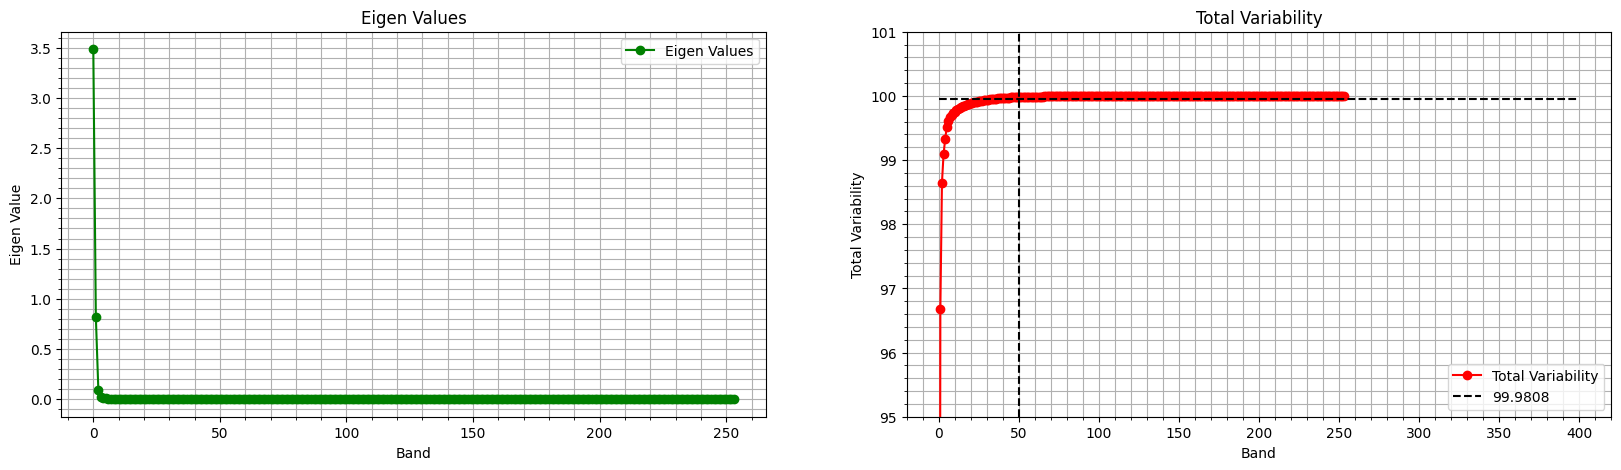

In [20]:
## PCA

dataset_flat = hsi_data.load().reshape(hsi_data.shape[0] * hsi_data.shape[1], hsi_data.shape[2])
for i in range(dataset_flat.shape[1]):
    dataset_flat[:, i] = (dataset_flat[:, i] - np.mean(dataset_flat[:, i]))
m = dataset_flat.shape[0]
covariance_matrix = np.dot(dataset_flat.T, dataset_flat) / (m - 1)
eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
principal_components = np.dot(dataset_flat, eigen_vectors)

# plot of band vs eigen values and total variability

def tv(eigen_values):
    total_variability = []
    for i in range(len(eigen_values)):
        intermediate = np.sum(eigen_values[:i+1])
        tv = intermediate / np.sum(eigen_values) * 100          # percent variability
        total_variability.append(tv)
            

    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(eigen_values, 'o-', color='green', label='Eigen Values')
    axs[0].set_title('Eigen Values')
    axs[0].set_xlabel('Band')
    axs[0].set_ylabel('Eigen Value')
    axs[0].grid(which='both')
    axs[0].minorticks_on()
    axs[0].legend()

    axs[1].plot(total_variability, 'o-', color='red', label='Total Variability')
    axs[1].set_title('Total Variability')
    axs[1].set_xlabel('Band')
    axs[1].set_ylabel('Total Variability')
    axs[1].grid(which='both')
    axs[1].vlines(50, 95, 101, color='black', linestyles='dashed')
    axs[1].hlines(99.949, 0, 400, color='black', linestyles='dashed', label=round(total_variability[50],4))
    axs[1].minorticks_on()
    plt.ylim(95,101)
    axs[1].legend(loc='lower right')
    plt.show()
    return None  
tv(eigen_values)


In [21]:
## Keeping just 50 eigen vectors corresponding to 99.98% variability

selected_eigen_vectors = eigen_vectors[:, :50]
principal_components_hsi = np.dot(dataset_flat, selected_eigen_vectors)
hsi_data_pca = principal_components_hsi.reshape(thor_hsi_data.shape[0], thor_hsi_data.shape[1], 50)

## Projecting the reference spectrum to PC space

reference_spectrum_pca = np.dot(reference_spectrum, selected_eigen_vectors)
reference_spectrum_pca = reference_spectrum_pca.reshape(50)

**Plotting Few PC components and reference spectrum projected into the pc space With just 50 bands**

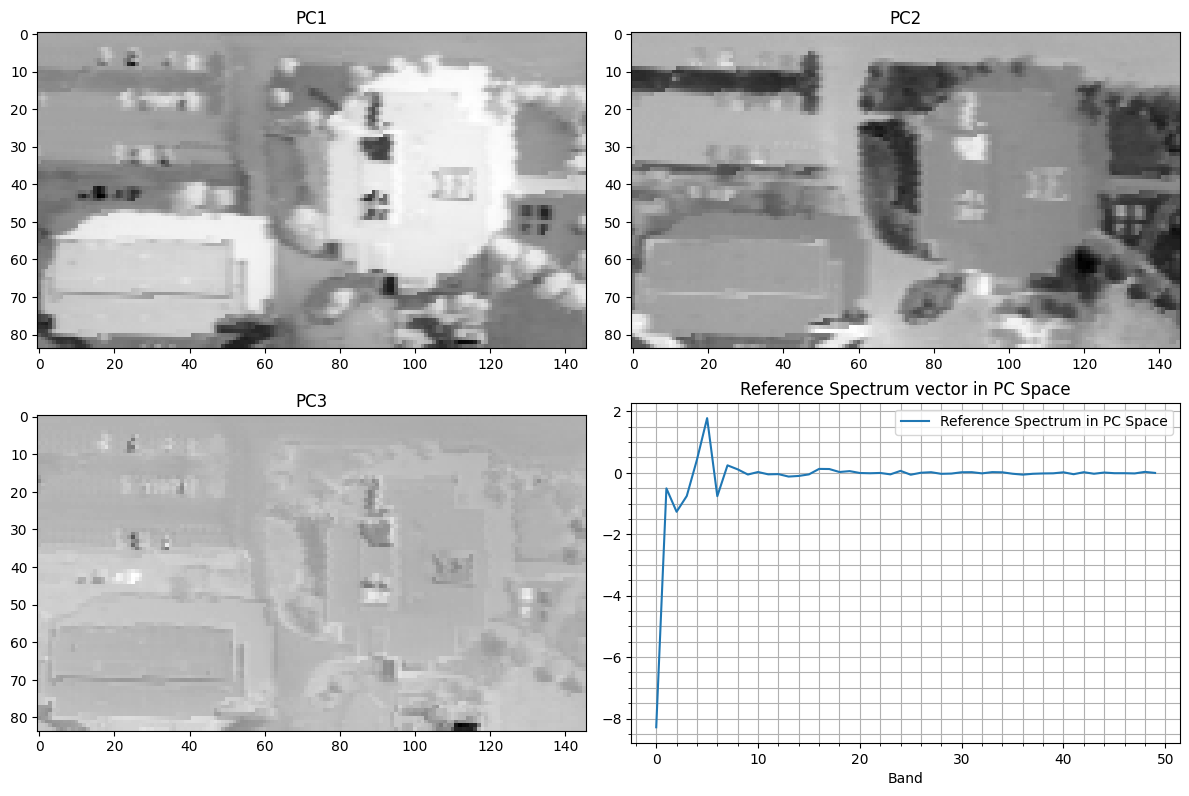

In [22]:
## Plotting first 3 bands of HSI data in PC space and reference spectrum in PC space

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].imshow(hsi_data_pca[:, :, 0], cmap='gray')
axs[0, 0].set_title('PC1')

axs[0, 1].imshow(hsi_data_pca[:, :, 1], cmap='gray')
axs[0, 1].set_title('PC2')

axs[1, 0].imshow(hsi_data_pca[:, :, 2], cmap='gray')
axs[1, 0].set_title('PC3')

axs[1, 1].plot(reference_spectrum_pca, label='Reference Spectrum in PC Space')
axs[1, 1].set_title('Reference Spectrum vector in PC Space')
axs[1, 1].set_xlabel('Band')
axs[1, 1].grid(which='both')
axs[1, 1].minorticks_on()
axs[1, 1].legend()
plt.tight_layout()
plt.show()

#### **Applying Detection in PC space now**

**Spectral Angle Mapper**

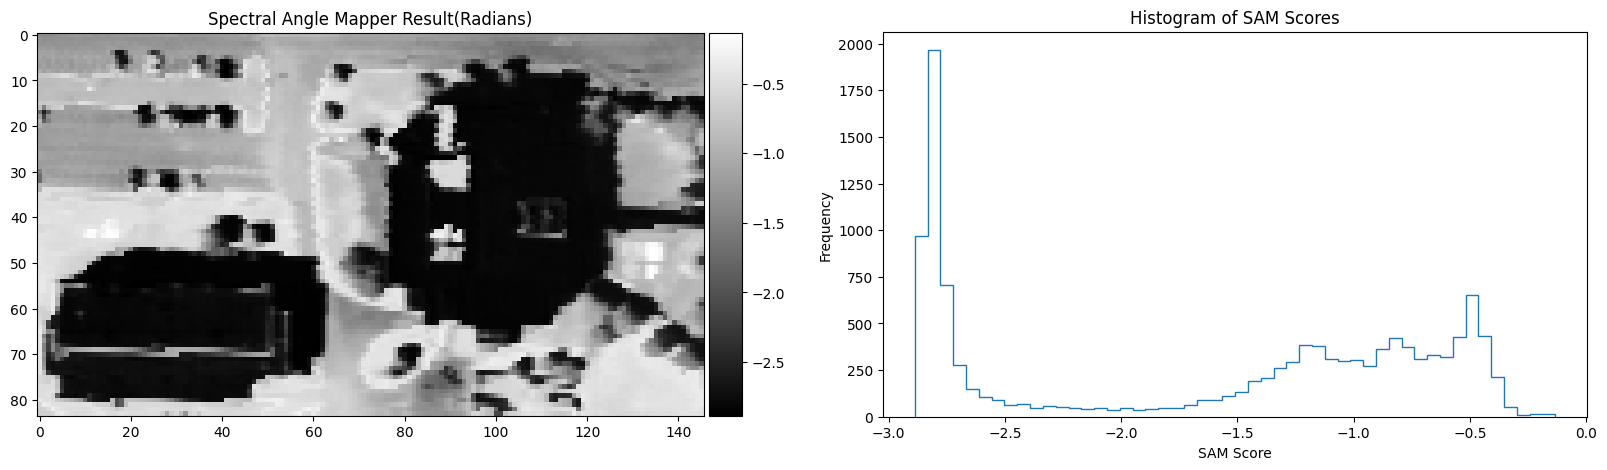

In [23]:
## Spectral Angle Mapper in PC space

sam_result_pca = calculate_sam(hsi_data_pca, reference_spectrum_pca)

## Plot the SAM result
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
im = axs[0].imshow(sam_result_pca, cmap='gray')
axs[0].set_title('Spectral Angle Mapper Result(Radians)')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

## Plot the histogram of the SAM scores
axs[1].hist(sam_result_pca.ravel(), bins=50, histtype='step')
axs[1].set_title('Histogram of SAM Scores')
axs[1].set_xlabel('SAM Score')
axs[1].set_ylabel('Frequency')
plt.show()

**Spectral Matched Filter**

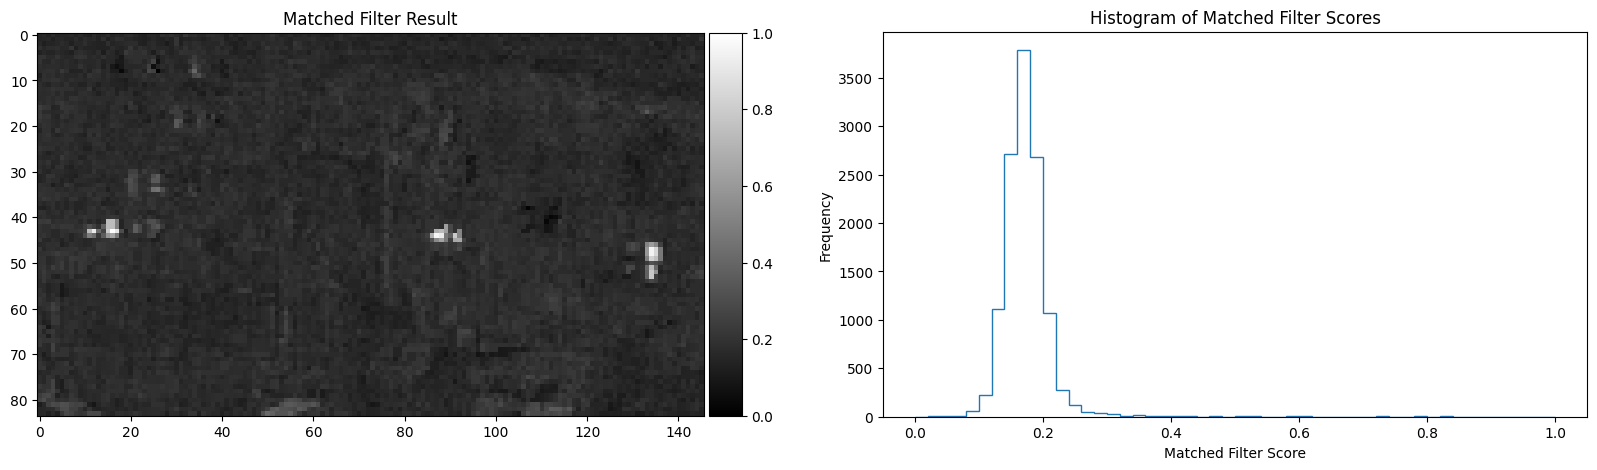

In [24]:
## Matched Filter in PC space

matched_filter_result_pca = calculate_matched_filter(hsi_data_pca, reference_spectrum_pca)

## Plot the matched filter result
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
im = axs[0].imshow(matched_filter_result_pca, cmap='gray')
axs[0].set_title('Matched Filter Result')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

## Plot the histogram of the matched filter scores
axs[1].hist(matched_filter_result_pca.ravel(), bins=50, histtype='step')
axs[1].set_title('Histogram of Matched Filter Scores')
axs[1].set_xlabel('Matched Filter Score')
axs[1].set_ylabel('Frequency')
plt.show()

**Adaptive Cosine Estimator**

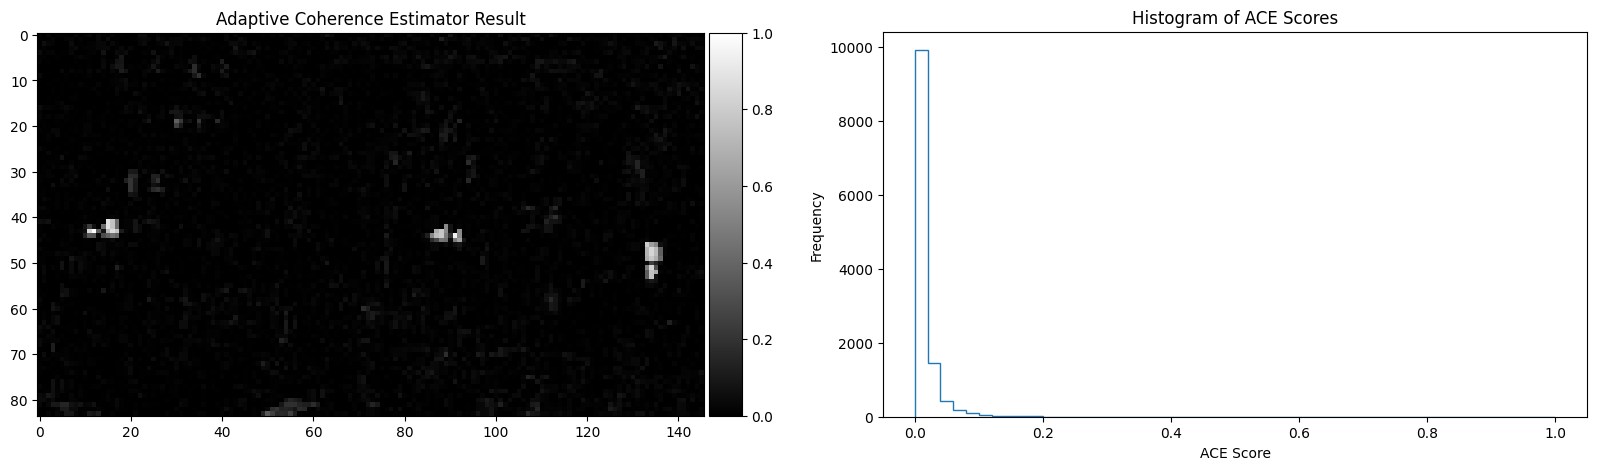

In [25]:
## ACE in PC space

ace_result_pca = calculate_ace(hsi_data_pca, reference_spectrum_pca)

## Plot the ACE result
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
im = axs[0].imshow(ace_result_pca, cmap='gray')
axs[0].set_title('Adaptive Coherence Estimator Result')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

## Plot the histogram of the ACE scores
axs[1].hist(ace_result_pca.ravel(), bins=50, histtype='step')
axs[1].set_title('Histogram of ACE Scores')
axs[1].set_xlabel('ACE Score')
axs[1].set_ylabel('Frequency')
plt.show()


**Constrained Energy Minimization**

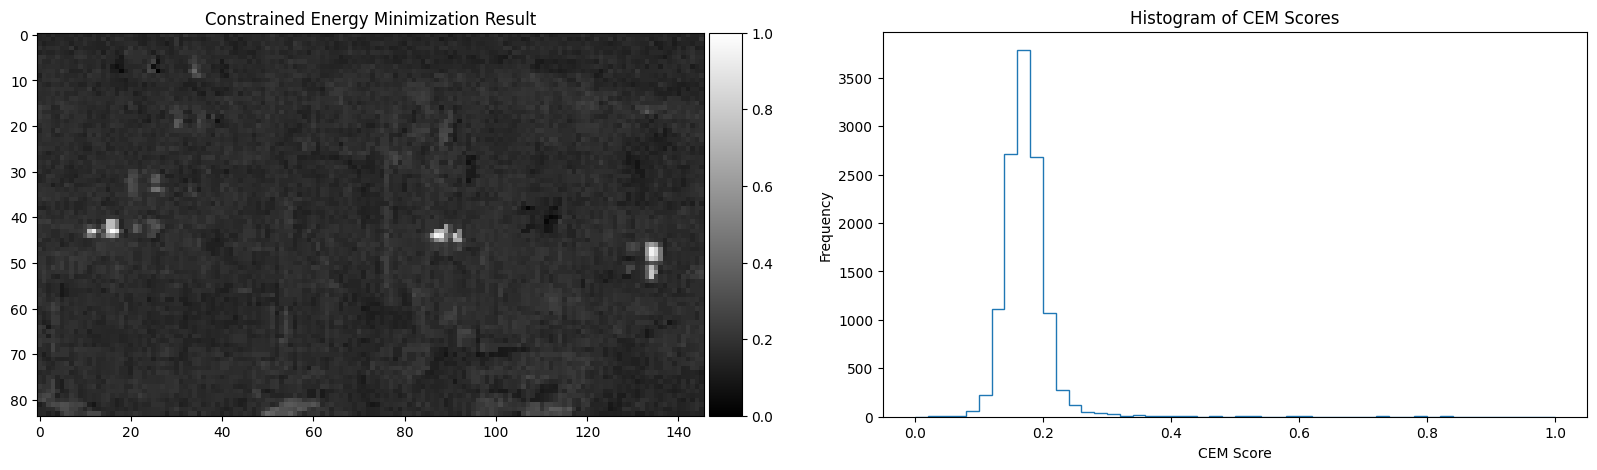

In [26]:
## CEM in PC space

cem_result_pca = calculate_cem(hsi_data_pca, reference_spectrum_pca)

## Plot the CEM result
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
im = axs[0].imshow(cem_result_pca, cmap='gray')
axs[0].set_title('Constrained Energy Minimization Result')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

## Plot the histogram of the CEM scores
axs[1].hist(cem_result_pca.ravel(), bins=50, histtype='step')
axs[1].set_title('Histogram of CEM Scores')
axs[1].set_xlabel('CEM Score')
axs[1].set_ylabel('Frequency')
plt.show()


**Q3B: Thresholding in PC Space**


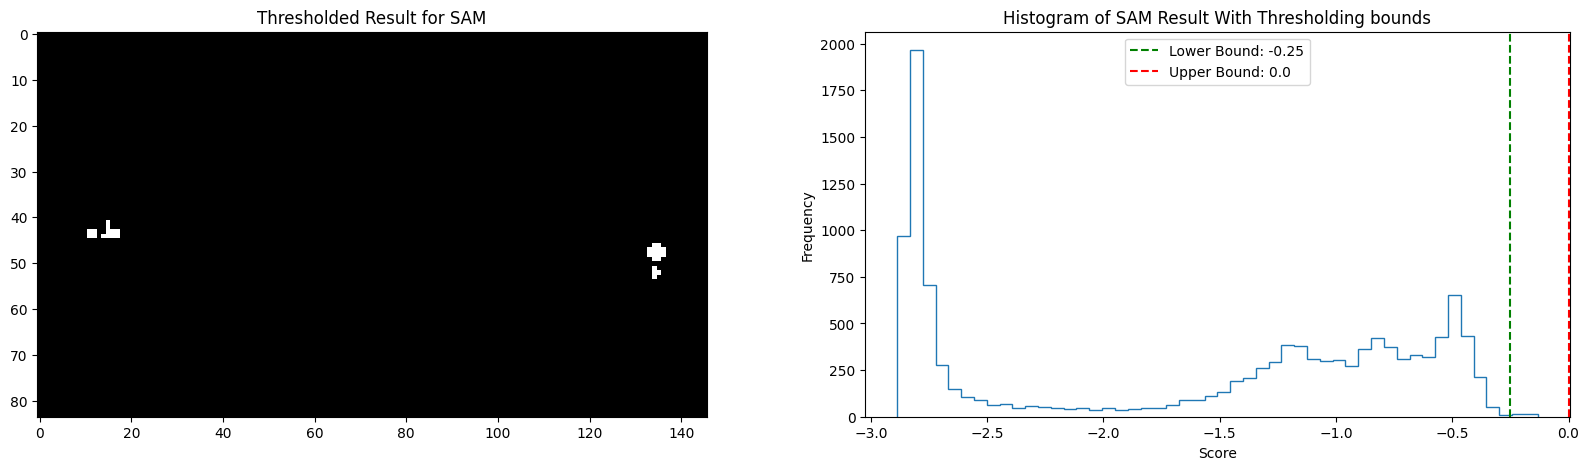

In [27]:
## Thresholding the SAM result
thresholding(sam_result_pca, -0.25, 0.0, 'SAM')

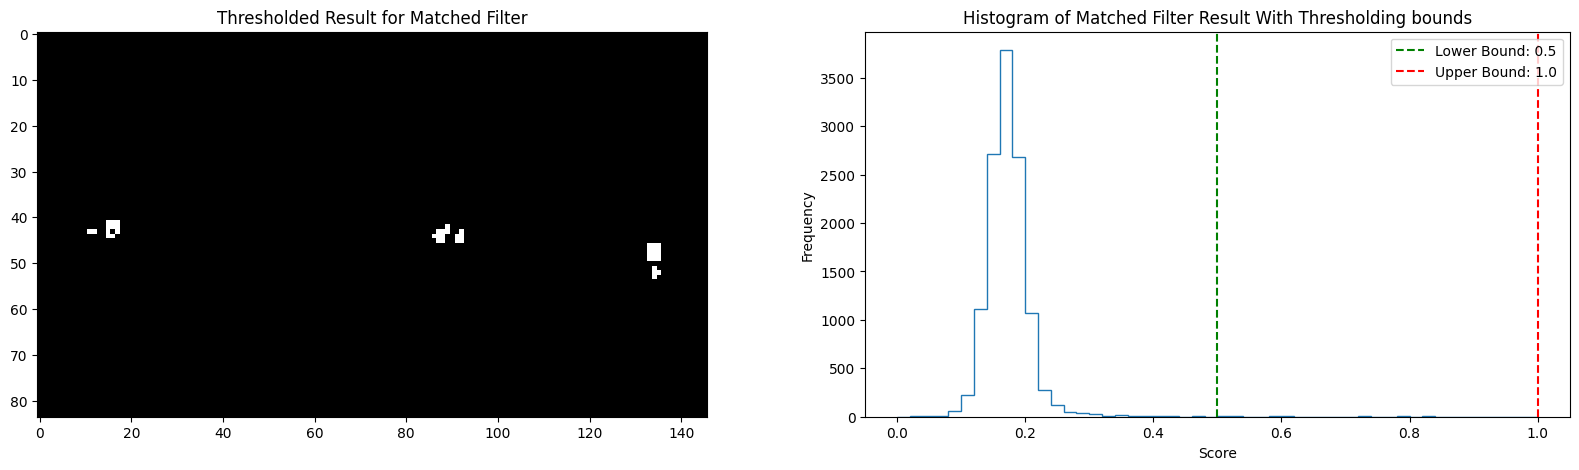

In [28]:
## Thresholding the matched filter result
thresholding(matched_filter_result_pca, 0.5, 1.0, 'Matched Filter')

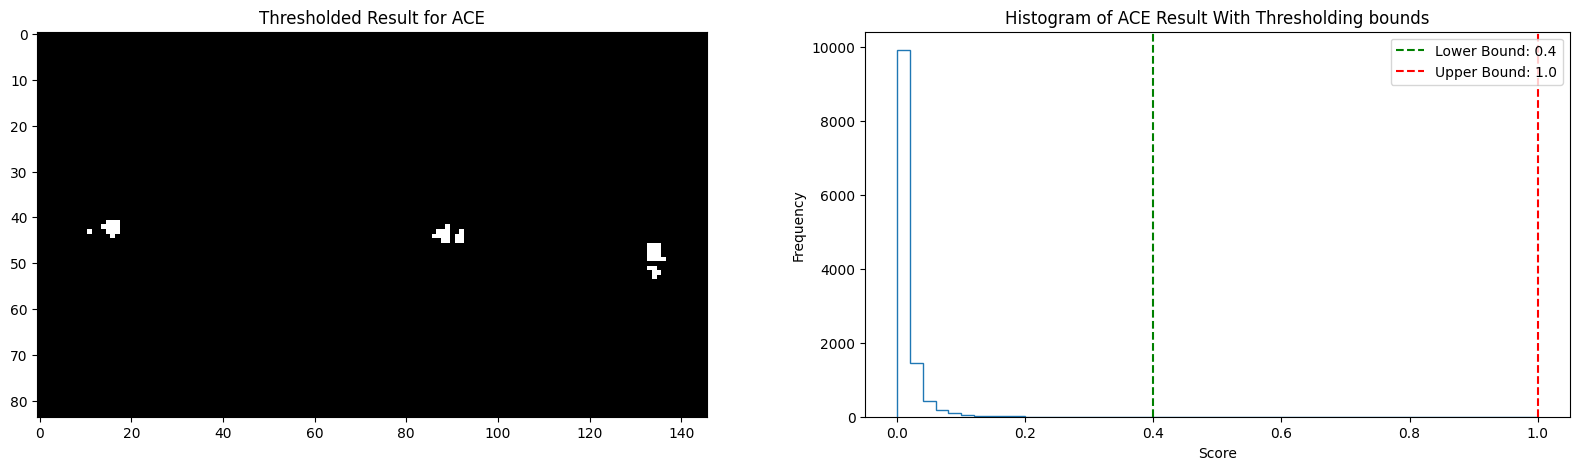

In [29]:
## Thresholding the ACE result
thresholding(ace_result_pca, 0.4, 1.0, 'ACE')

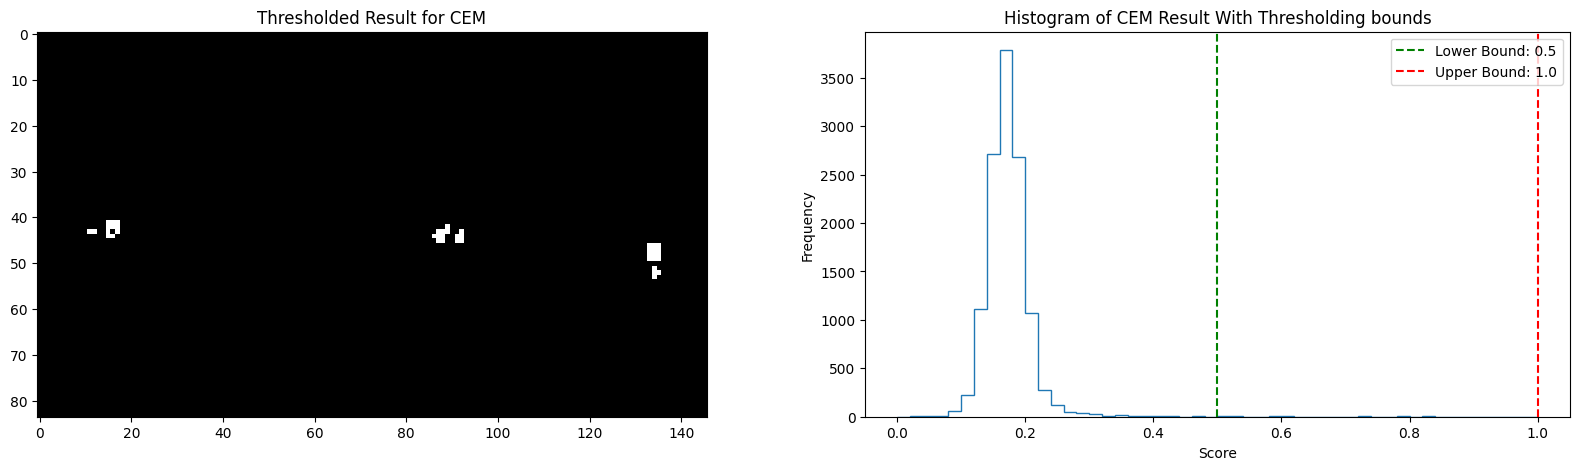

In [30]:
## Thresholding the CEM result
thresholding(cem_result_pca, 0.5, 1.0, 'CEM')

**Q3C: Building ROC curves for detection**

/var/folders/_z/xfqh2srd4zg69mc724gvhc6m0000gn/T/ipykernel_37549/1180817907.py:20: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(hit_rate, all_pixels / np.max(all_pixels))


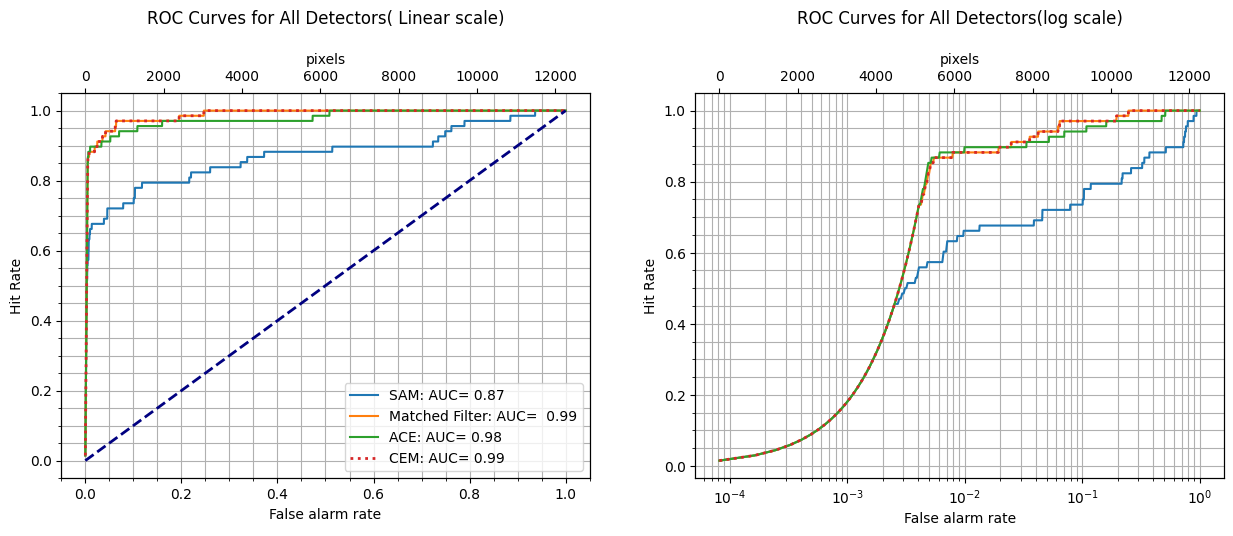

In [31]:
## ROC curve for all detectors
all_roc(sam_result_pca, matched_filter_result_pca, ace_result_pca, cem_result_pca, class_map)

**Q4b: Comment On:**  
i.	The detector results in spectral and reduced space.  
ii.	What impact you think the truth mask might have on your findings  
iii.	Does reduced space help at all in locating targets.  

Analysing the results above we can see that detection in PC space is able to find more target than in original space. Looking at ROC curve we can see that area under curve for "Matched Filter" and "Constrained Energy Minimization" is almost the same and higher than "SAM" and "ACE" algorithms in both spaces. SAM perform below all other detecors. Comparing the detection ability between two spaces the AUC in reduced space is more for all the detector than the original space which we can even see in threshold results for each detector. This may be because reducing dimension in PC space by neglecting higher order PC components have effect of reducing noise components in the image that may be increasing the detection of targets. However in both spaces we were not able to find the red panel in shadow target without introducing noise in the detection. 

Regarding the truth mask, the more accurate the truth mask is the more accurate performance analysis we can get. And the choice of truth mask using envi is subjective which will effect more or less of our performance metrics i.e. ROC curve. 
